In [59]:
import math
import torch
import matplotlib.pyplot as plt

In [60]:
import torch.nn as nn
import numpy as np

import torch
import torch.optim

from abc import ABC, abstractmethod

class Bump(torch.nn.Module):
    
    '''Implements a bum over the interval [a,b]'''
    
    def __init__(self, 
                 a = 0.99,
                 b=1.0, 
                 scale=100.0,
                 normalize=True):
        
        super().__init__()
        
        self.b = b
        self.a = a
        self.scale = scale
        self.normalize = normalize
        
        self.norm = 0.3679 if normalize else 1.0
        self.indicator = IntervalIndicator(a=0.0,b=1.0,scale=scale)
        self.relu = torch.nn.ReLU()
        self.shift = IntervalShift(a=a,b=b)
        
    def forward(self,x):
        
        x = self.shift(x)
        y = self.indicator(x)
        z = 1-(((2*(x-1))) + 1)**2
        x = (torch.exp(-(1/z))*y)/self.norm

        return x
    
class IntervalShift(torch.nn.Module):
    
    #from: https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    '''
    Maps [a,b] bijectiv onto the interval [c,d] with f(a)=c and f(b)=d
    '''
    def __init__(self, a=0.0, b=1.0, c=0.0,d=1):
        super().__init__()
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        
    def forward(self,x):
        return self.c + ((self.d-self.c)/(self.b-self.a))*(x-self.a)
    
class Sawtooth(torch.nn.Module):
    
    '''Implements a sawtooh function over the interval [a,b]'''
    
    def __init__(self, 
                 a=0.0, 
                 b=1.0, 
                 dim=None):
        
        super().__init__()
        
        if not isinstance(a,torch.Tensor):
            a = torch.tensor([a])
        if not isinstance(b,torch.Tensor):
            b = torch.tensor([b])
        
        if dim is not None:
            a = torch.ones((dim,dim))*a
            b = torch.ones((dim,dim))*b
        
        self.a = a
        self.b = b
        
        self.relu = torch.nn.ReLU()
        self.shift = IntervalShift(a=a,b=b)
        
    def forward(self,x):
        x = (1/(self.b-self.a))*(x - self.a)
        x = 2*self.relu(x)-4*self.relu(x-0.5) + 2*self.relu(x-2)
        x = self.relu(x)
        return x

    
class IntervalIndicator(torch.nn.Module):
    
    '''Implements the indicator function over the interval [a,b]'''
    
    def __init__(self,
                 a=0.0, 
                 b=1.0, 
                 dim=None,
                 scale=1000.0):

        super().__init__()
        
        self.scale = scale
        
        self.sawtooth = Sawtooth(a=a,b=b,dim=dim)
        self.sigmoid = torch.nn.Sigmoid()   

        
    def forward(self, x):
        x = self.sawtooth(x)
        x =  2*(self.sigmoid(self.scale*x)-0.5)
        return x
    
class BaseNN(nn.Module):
    
    '''Constraines any dynamics to stay in [a,b]'''
    def __init__(self,
                 dif,
                 n=8,
                 a = 0.0,
                 b=1.0,
                 scale=1000.0,
                 eps=1e-8,
                 normalize=True,
                 init_weights=False,
                 weight_std=0.1):

        super(BaseNN,self).__init__()
        
        self.dif = dif
            
        self.a = a
        self.b = b
        self.eps = eps
        self.bump = Bump(a=a,b=b,scale=scale,normalize=normalize)
        
        self.weight_std = weight_std
        
        if init_weights:
            self.apply(self._init_weights)
        
        self.relu = torch.nn.ReLU()
        
    def forward(self,v):
                
        #calculate mu_tilde and signam_tilde from figure 4 of https://arxiv.org/pdf/2105.11053.pdf
        v = v[:,0]
        mu_tilde = self.dif.f(v)
        sigma_tilde = self.dif.g(v)
        
        #given mu_tilde and signam_tilde apply the calculations from section 3.3 in https://arxiv.org/pdf/2105.11053.pdf
        #to constrain the underlying SDE to [a,b]
        
        diff_scale = self.bump(v)
        sigma = diff_scale*sigma_tilde
        mu = self.corrected_drift(mu_tilde,v)
        
        return mu, sigma
    
    def _init_weights(self,m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight,std=self.weight_std)
            torch.nn.init.normal_(m.bias,std=self.weight_std)
    
    def corrected_drift(self, mu_tilde, x):
        
        ceta_a = self.b+2*self.eps
        ceta_b = self.a - 2*self.eps
        
        lam_a = self.drift_weights(mu_tilde,x,ceta_a,1)
        lam_b = self.drift_weights(mu_tilde,x,ceta_b,-1)
        return mu_tilde + lam_a*(ceta_a-x) + lam_b*(ceta_b-x)
    
    def drift_weights(self,mu_tilde,x,ceta,v):
        
        z1 = v*mu_tilde - self.correct_term(x)
        z2 = v*(ceta-x)
        
        return self.relu(z1/z2)
    
    def correct_term(self,x):
        z1 = torch.exp(x) -1
        z2 = np.exp(self.eps) - 1
        return (1/(2*self.eps))*(z1/z2)

## Sawtooth function over [a,b]

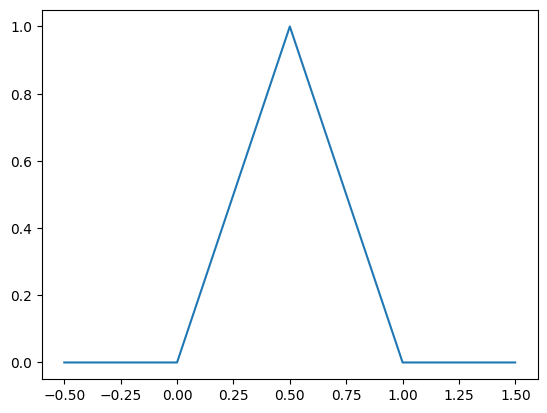

In [61]:
a = 0
b = 1
x = torch.arange(a-0.5,b+0.5,0.001)

sawtooth = Sawtooth(a=a,b=b)
y = sawtooth(x)
plt.plot(x,y)

## Indicator function on [a,b]

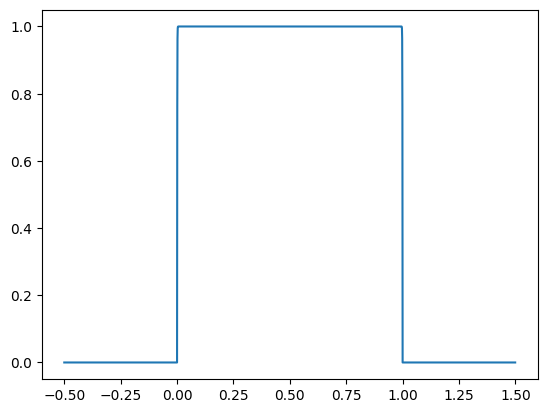

In [51]:
a = 0.0
b = 1
x = torch.arange(a-0.5,b+0.5,0.001)

indicator = IntervalIndicator(a=a,b=b)
y = indicator(x)
plt.plot(x,y)

## Bump function on [a,b]

tensor(0.3679)


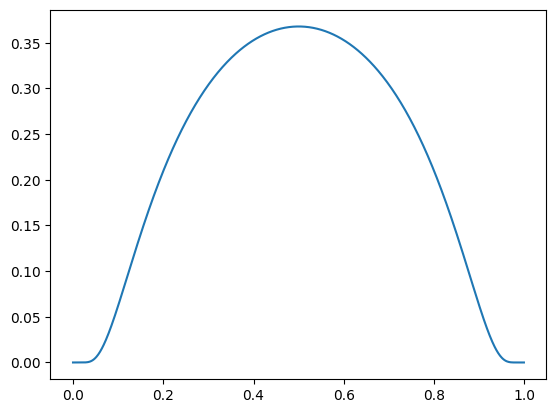

In [52]:
a = 0
b = 1 
x = torch.arange(a,b,0.001)

indicator = Bump(a=a,b=b,normalize=False)
y = indicator(x)
print(y.max())
plt.plot(x,y)


In [53]:
class JacobiDiffusionProcess():
    def __init__(self, s=1.0, a=1.0,b=1.0,device="cpu"):
        super(JacobiDiffusionProcess, self).__init__()
        
        #a and b are not related to a,b notation from above.
        #here it cooresponds to the dynamics of DDSM, above a and b are just the interval boundaries
        self.s = s
        self.a = a
        self.b = b
        
        self.device = device
        
        self.base_nn = BaseNN(dif=self, a=0.0,b=1.0,normalize=True,scale=10**6)
    
    def coef_compute(self,v0):
        return self.base_nn(v0)
    
    def coef_func(self,v,dt):
        return self.constrained_coef(v,dt=dt)
    
    def constrained_coef(self,v,dt=0.001):
        
        a,b = self.coef_compute(v)
    
        a_norm = 1. + torch.linalg.norm(a)*torch.sqrt(dt)
        b_norm = 1. + torch.linalg.norm(b)*torch.sqrt(dt)
        
        drift = a/a_norm
        dif = b/b_norm
        
        return drift[:,None], dif[:,None]

    def f(self,v):
        return 0.5*self.s*(self.a*(1-v)-self.b*v)
    
    def g(self,v):
        return torch.sqrt(self.s*v*(1-v))


torch.Size([10000, 1]) torch.Size([10000, 1]) torch.Size([10000, 1]) torch.Size([10000, 1])
V_clamp.shape: torch.Size([10000, 2001, 1])
V_metro.shape: torch.Size([10000, 2001, 1])
V_reflect.shape: torch.Size([10000, 2001, 1])
Clamping method has values outside of [0,1] tensor(False)
Metropolis method has values outside of [0,1] tensor(False)
Constrained diffusion has values outside of [0,1] tensor(False)
Reflect method has values outside of [0,1] tensor(False)



KeyboardInterrupt



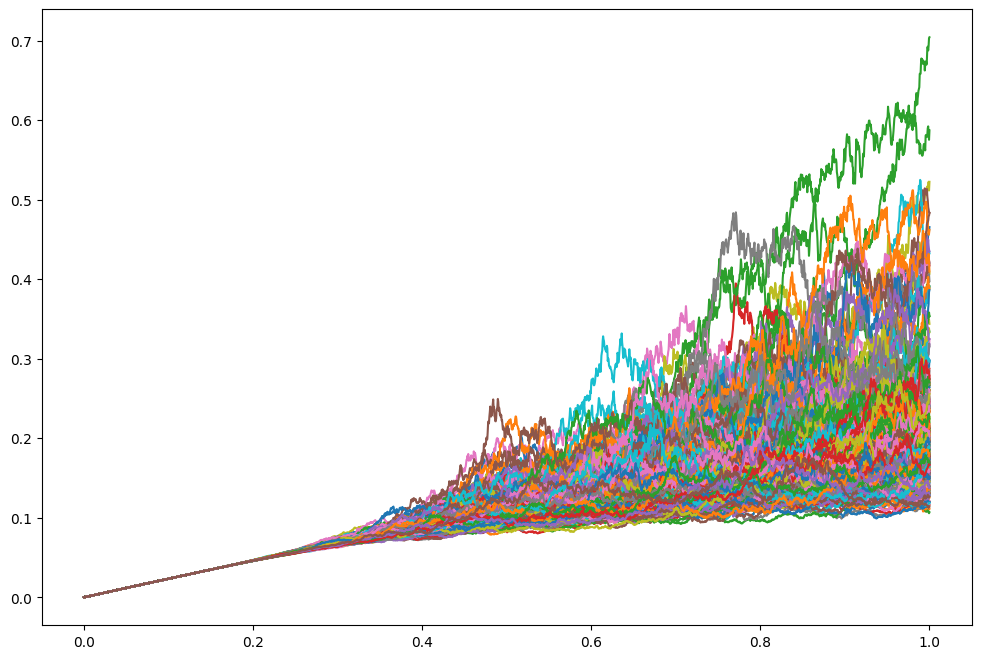

In [58]:
def get_brownian(M=100,N=1000,D=1,T=1.0):

    t = torch.arange(N+1)/N # t=0,1/N,2/N,...,N/N
    dt = torch.tensor(T/N)
    dW = torch.sqrt(dt)*torch.randn(M,N,D)
    
    return t,dt,dW

def init(M=100,N=1000,D=1, x0=None,eps=1e-5):
    if x0 is None:
        V=torch.ones(M,N+1,D)-eps
        V[:int(M/2)] = eps
    else:
        V = x0*torch.ones(M,N+1,D) -eps*x0 + eps*(1-x0)
    return V

def reflect(x):
    """
    Performs reflections until x is inside the domain.

    Args
    ----
    x (Tensor):
        input of shape [B, ...]

    Returns
    -------
    an output Tensor with the same shape as x which is the "reflected"-inside version.
    """
    xm2 = x % 2
    xm2[xm2 > 1] = 2 - xm2[xm2 > 1]
    return xm2

'''
def reflect(x):
    
    #I think we don't need the while loop, applying simply the code from reflceted diffusion above works
    """
    Reflects values to ensure they are within the [0, 1] interval.
    """
    # Reflect any values falling outside the [0, 1] interval
    while True:
        # Values less than 0 are reflected from the negative side
        mask = x < 0
        x[mask] = -x[mask]

        # Values greater than 1 are reflected from above 1
        mask = x > 1
        x[mask] = 2 - x[mask]

        # If no values are outside [0, 1], stop
        if not (x < 0).any() and not (x > 1).any():
            break
    return x

'''

def clamp_step(v0, dt, dw, jdp):
    return torch.clamp(v0 + jdp.f(v0)*dt+ jdp.g(v0)*dw,min=0.0,max=1.0) 

def metro_step(v0, dt, dw, jdp):

    v1 = v0 + jdp.f(v0)*dt+ jdp.g(v0)*dw
    mask = (v1 > 0)*(v1 < 1) #mask is False for any entry outside of [0,1] 
    mask = ~mask #mask is True for any entry outside of [0,1] 
    while torch.any(mask):
        dw_new = torch.sqrt(dt)*torch.randn(dw[mask].shape)
        v1[mask] = v0[mask] + jdp.f(v0[mask])*dt+ jdp.g(v0[mask])*dw_new
        mask = ~((v1 > 0)*(v1 < 1)) #mask is True for any entry outside of [0,1] 
        
    return v1

def constrained_step(v0, dt, dw, jdp):
    drift, dif = jdp.coef_func(v0,dt=dt)
    #mask = (v0>0.0)*(v0<1.0)
    #dif = torch.zeros_like(v0)
    #dif[mask] = jdp.g(v0[mask])
    return v0 + drift*dt+ dif*dw

def reflect_step(v0, dt, dw, jdp):
    # 计算下一步的预测值
    v1 = v0 + jdp.f(v0) * dt + jdp.g(v0) * dw
    # 应用反射，确保所有值都在[0, 1]区间内
    v1_reflected = reflect(v1)
    return v1_reflected

def plot(t,X,name='Clamping'):
    plt.figure(figsize=(12, 8))
    for i in range(X.shape[0]):
            plt.plot(t,X[i,:,0])
    plt.title(name)
    plt.show()
    return

def compare_sampling(M=100, N=1000, D=1, T=1.0, s=1.0, a=1.0, b=1.0, eps=1e-5, x0=None):

    t,dt,dW = get_brownian(M=M,N=N,D=D,T=T)
    
    V_clamp = init(M=M,N=N,D=D, x0=x0,eps=eps)
    V_metro = init(M=M,N=N,D=D, x0=x0,eps=eps)
    V_con = init(M=M,N=N,D=D, x0=x0,eps=eps)
    V_reflect= init(M=M,N=N,D=D, x0=x0,eps=eps)
    
    jdp = JacobiDiffusionProcess(s=s, a=a,b=b)
    
    v0_clamp = V_clamp[:,0,:]
    v0_metro = V_metro[:,0,:]
    v0_con = V_con[:,0,:]
    v0_reflect= V_reflect[:,0,:]
    print()
    print(v0_clamp.shape, v0_metro.shape, v0_con.shape, v0_reflect.shape)
    
    for i in range(N):
        
        v1_clamp = clamp_step(v0_clamp,dt,dW[:,i,:],jdp)
        v1_metro = metro_step(v0_metro,dt,dW[:,i,:],jdp)
        v1_con = constrained_step(v0_con,dt,dW[:,i,:],jdp)
        v1_reflect = reflect_step(v0_reflect,dt,dW[:,i,:],jdp)
        
        V_clamp[:,i+1] = v1_clamp
        V_metro[:,i+1] = v1_metro
        V_con[:,i+1] = v1_con
        V_reflect[:,i+1] = v1_reflect
        
        v0_clamp = v1_clamp
        v0_metro = v1_metro
        v0_con = v1_con
        v0_reflect = v1_reflect
        
    return t,V_clamp, V_metro, V_con, V_reflect


############# Random Test ############
M= 10000
N= 2000
t,V_clamp, V_metro, V_con, V_reflect = compare_sampling(M=M,N=N)

print('V_clamp.shape:', V_clamp.shape)
print('V_metro.shape:', V_metro.shape)
print('V_reflect.shape:', V_reflect.shape)

print('Clamping method has values outside of [0,1]',(V_clamp > 1).any() or (V_clamp < 0).any())
print('Metropolis method has values outside of [0,1]',(V_metro > 1).any() or (V_metro < 0).any())
print('Constrained diffusion has values outside of [0,1]',(V_con > 1).any() or (V_con < 0).any())
print('Reflect method has values outside of [0,1]',(V_reflect > 1).any() or (V_reflect < 0).any())

plot(t,V_clamp,name='Clamping')
plot(t,V_metro,name='Metropolis')
plot(t,V_reflect,name='Reflected')
plot(t,V_con,name='Constrained Diffusion')

In [56]:
import seaborn as sns

/home/fe/nobis/anaconda3/envs/gfdm/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/fe/nobis/anaconda3/envs/gfdm/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fe/nobis/anaconda3/envs/gfdm/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/fe/nobis/anaconda3/envs/gfdm/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

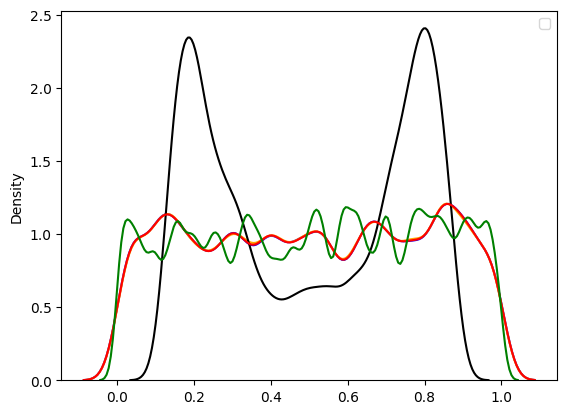

In [57]:
U = torch.rand(M)
sns.kdeplot(V_clamp[:, N, 0],bw_method=0.1,color='blue',legend='clamping')
sns.kdeplot(V_metro[:, N, 0],bw_method=0.1,color='orange',legend='metropolis')
sns.kdeplot(V_con[:, N, 0],bw_method=0.1,color='black',legend='constrained')
sns.kdeplot(V_reflect[:, N, 0],bw_method=0.1,color='red',legend='reflect')
sns.kdeplot(U,bw_method=0.05,color='green',legend='uniform')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


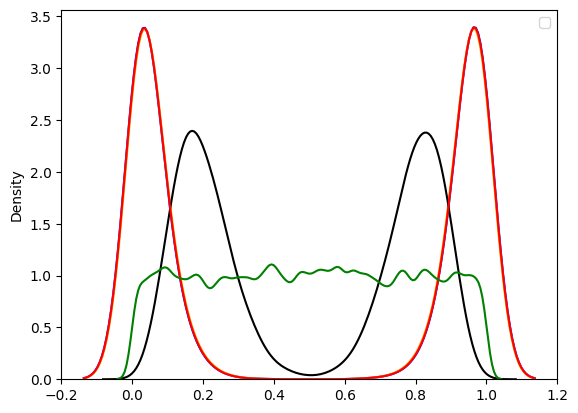

In [6]:
U = torch.rand(M)
sns.kdeplot(V_clamp[:, int(N/10), 0],bw_method=0.1,color='blue',legend='clamping')
sns.kdeplot(V_metro[:, int(N/10), 0],bw_method=0.1,color='orange',legend='metropolis')
sns.kdeplot(V_con[:, int(N/10), 0],bw_method=0.1,color='black',legend='constrained')
sns.kdeplot(V_reflect[:, int(N/10), 0],bw_method=0.1,color='red',legend='reflect')
sns.kdeplot(U,bw_method=0.05,color='green',legend='uniform')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


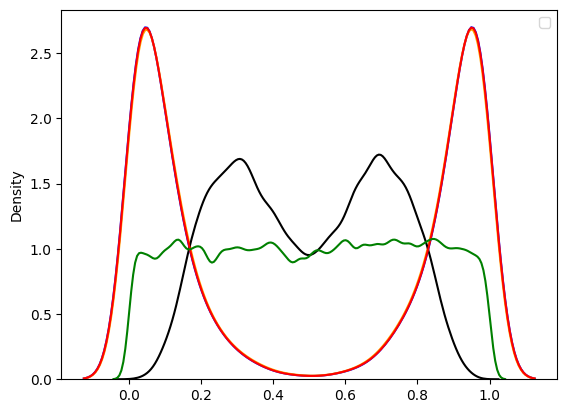

In [7]:
U = torch.rand(M)
sns.kdeplot(V_clamp[:, int(N/5), 0],bw_method=0.1,color='blue',legend='clamping')
sns.kdeplot(V_metro[:, int(N/5), 0],bw_method=0.1,color='orange',legend='metropolis')
sns.kdeplot(V_con[:, int(N/5), 0],bw_method=0.1,color='black',legend='zero')
sns.kdeplot(V_reflect[:, int(N/5), 0],bw_method=0.1,color='red',legend='reflect')
sns.kdeplot(U,bw_method=0.05,color='green',legend='uniform')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


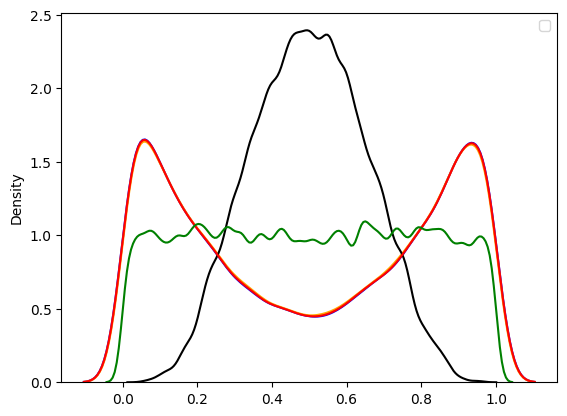

In [8]:
U = torch.rand(M)
sns.kdeplot(V_clamp[:, int(N/2), 0],bw_method=0.1,color='blue',legend='clamping')
sns.kdeplot(V_metro[:, int(N/2), 0],bw_method=0.1,color='orange',legend='metropolis')
sns.kdeplot(V_con[:, int(N/2), 0],bw_method=0.1,color='black',legend='zero')
sns.kdeplot(V_reflect[:, int(N/2), 0],bw_method=0.1,color='red',legend='reflect')
sns.kdeplot(U,bw_method=0.05,color='green',legend='uniform')
plt.legend()
plt.show()